<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Summarization Classification Evals</h1>

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to evaluating summarization quality,
- to provide an experimental framework for users to iterate and improve on the default classification template.

## Install Dependencies and Import Libraries

In [1]:
#####################
## N_EVAL_SAMPLE_SIZE
#####################
#Eval sample size determines the run time
#100 samples: GPT-4 ~ 80 sec / GPT-3.5 ~ 40 sec
#1,000 samples: GPT-4 ~15-17 min / GPT-3.5 ~ 6-7min (depending on retries)
#10,000 samples GPT-4 ~170 min / GPT-3.5 ~ 70min
N_EVAL_SAMPLE_SIZE = 100

In [2]:
!pip install -qq arize-phoenix ipython matplotlib openai pycm scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 77.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import openai
import pandas as pd
import phoenix.experimental.evals.templates.default_templates as templates
from phoenix.experimental.evals import (
    OpenAIModel,
    download_benchmark_dataset,
    llm_eval_binary,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of an LLM model and settings in addition to an evaluation prompt template against benchmark datasets of queries and retrieved documents with ground-truth relevance labels. We will be using the CNN Daily News Mail dataset. This dataset is commonly used for text summarization models as a benchmark.

In [4]:
df = pd.read_parquet("https://storage.googleapis.com/arize-assets/fixtures/Embeddings/GENERATIVE/cnndn_summarization.snappy.pq")
df.head()

document  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   This is the moment when an angry woman forced an elderly man to kneel in the street after he accidentally knocked her phone out of her hand. The video, filmed at an undisclosed location in China, sees the woman demand that the man pays compensation for her damaged phone as she slaps him in the middle of a busy road. Despite the elderly man promising to pay her back once he has the means to do so, she continues to berate him in front of witnesses, the People's Daily Online reports. Scroll down for video . Street attack: The shocking video was filmed after the elderly man knocked the woman's phone out of her hand, causing the screen to break . The shocking exchange was filmed by a witness and it had since gone viral on Chinese social media. The woman had allegedly been taking pictures of her children with her new iPhone 6 plus when the old man passed through on his moped. He accidentally bumped into the woman’s shoulder and her phone fell on the ground, and the screen cracked, the newspaper reports. The woman demanded the old man to compensate for repairing her phone, which he promised to do, but adding that it would have to wait as he did not have the money there and then. ‘The old man’s voice was trembling and he had tears in his eyes,’ a witnesses said, describing how the woman called four friends to the scene. Abuse: After being told that the man does not have the money to pay her back straight away, she is seen slapping him twice in the street . In the clip, the woman can be heard demanding that he pays her on the spot, despite his assurance that she will be compensated eventually . ‘The young woman’s friends hit the old man’s hat constantly and discussed whether they should really hit him,’the witness said. After a long verbal argument between the young woman and the old man, she is said to have demanded: ‘Kneel down for apology, then I will forget the money!’ The old man allegedly came off his moped, falling over as he kneeled down. 'His disability became appar

## Display Binary Summarization Classification Template

View the default template used to classify summarizations. You can tweak this template and evaluate its performance relative to the default.

In [5]:
print(templates.SUMMARIZATION_PROMPT_TEMPLATE_STR)


    You are comparing the summary text and it's original document and trying to determine
    if the summary is good. Here is the data:
    [BEGIN DATA]
    ************
    [Summary]: {summary}
    ************
    [Original Document]: {document}
    [END DATA]
    Compare the Summary above to the Original Document and determine if the Summary is
    comprehensive, concise, coherent, and independent relative to the Original Document.
    Your response must be a string, either Good or Bad, and should not contain any text
    or characters aside from that. Bad means that the Summary is not comprehensive, concise,
    coherent, and independent relative to the Original Document. Good means the Summary
    is comprehensive, concise, coherent, and independent relative to the Original Document.



Eval template variables:

- **document** : The document text to summarize
- **summary** : The summary of the document

## Configure the LLM

Configure your OpenAI API key.

In [7]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

## Benchmark Dataset Sample
Sample size determines run time
Recommend iterating small: 100 samples
Then increasing to large test set

In [8]:
df_sample = df.sample(n=N_EVAL_SAMPLE_SIZE).reset_index(drop=True)


## LLM Evals: Summarization Evals Classifications GPT-4
Run summarization classifications against a subset of the data.

Instantiate the LLM and set parameters.

In [9]:
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)

In [10]:
model("Hello world, this is a test if you are working?")

100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


"Hello! I'm working perfectly. How can I assist you today?"

In [11]:
#The rails is used to hold the output to specific values based on the template
#It will remove text such as ",,," or "..."
#Will ensure the binary value expected from the template is returned
rails = list(templates.SUMMARIZATION_PROMPT_RAILS_MAP.values())
summarization_classifications = llm_eval_binary(
    dataframe=df_sample,
    template=templates.SUMMARIZATION_PROMPT_TEMPLATE_STR,
    model=model,
    rails=rails,
)

100%|██████████| 100/100 [05:21<00:00,  3.21s/it]



Evaluate the predictions against human-labeled ground-truth summarization labels.

              precision    recall  f1-score   support

        Good       0.82      0.99      0.90        76
         Bad       0.89      0.33      0.48        24

    accuracy                           0.83       100
   macro avg       0.86      0.66      0.69       100
weighted avg       0.84      0.83      0.80       100



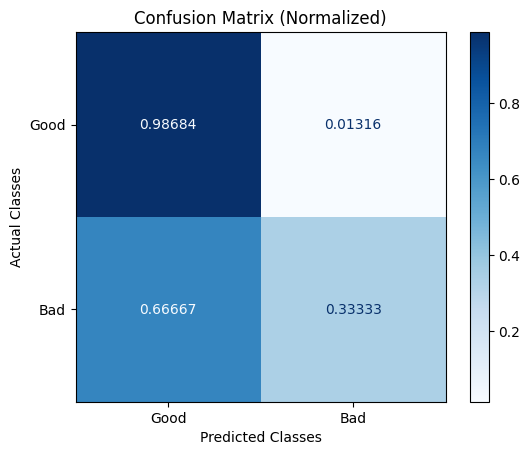

In [12]:
true_labels = df_sample["user_feedback"].map(templates.SUMMARIZATION_PROMPT_RAILS_MAP).tolist()
summarization_classifications= (
    pd.Series(summarization_classifications).map(lambda x: "unparseable" if x is None else x).tolist()
)
print(classification_report(true_labels, summarization_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=summarization_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
);


## LLM Evals: Summarization Evals Classifications GPT-3.5
Run summarization classifications against a subset of the data.

In [13]:
model = OpenAIModel(
    model_name="gpt-3.5-turbo",
    temperature=0.0,
    request_timeout=20
)

In [14]:

rails = list(templates.SUMMARIZATION_PROMPT_RAILS_MAP.values())
summarization_classifications = llm_eval_binary(
    dataframe=df_sample,
    template=templates.SUMMARIZATION_PROMPT_TEMPLATE_STR,
    model=model,
    rails=rails,
)

100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


              precision    recall  f1-score   support

        Good       0.82      0.12      0.21        76
         Bad       0.25      0.92      0.39        24

    accuracy                           0.31       100
   macro avg       0.53      0.52      0.30       100
weighted avg       0.68      0.31      0.25       100



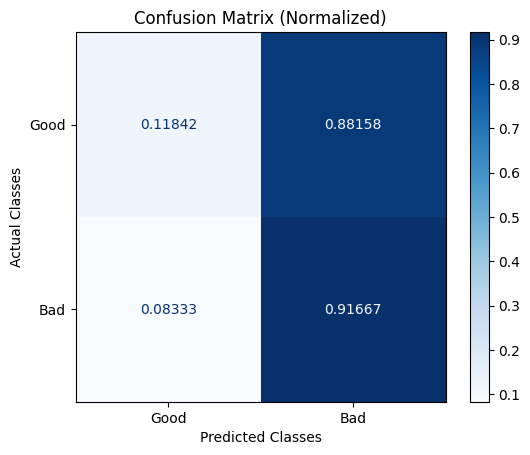

In [15]:
true_labels = df_sample["user_feedback"].map(templates.SUMMARIZATION_PROMPT_RAILS_MAP).tolist()
summarization_classifications= (
    pd.Series(summarization_classifications).map(lambda x: "unparseable" if x is None else x).tolist()
)

print(classification_report(true_labels, summarization_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=summarization_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
);